<a href="https://colab.research.google.com/github/uprestel/AutoNeRF/blob/master/pose_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pose estimation
In this Notebook we 
* load a trained VAE, a trained NeRF to generate images
* Next we generate a pose and an image at that pose 
* Finally, we learn to translate between a pose and a prior given the latent vector of our image


### Load imports

In [1]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F

!git clone https://github.com/uprestel/AutoNeRF.git

import AutoNeRF.data.data
import AutoNeRF.models.cinn as cinn
import AutoNeRF.models.blocks as blocks
import AutoNeRF.models.loss as cinn_loss
import AutoNeRF.models.nerf as nerf
import AutoNeRF.models.vae
import AutoNeRF.util.utils
#import AutoNeRF.cam_util
from AutoNeRF.util.transforms import random_rotation, look_at_rotation

import time
import os
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

import matplotlib as mpl
import matplotlib.pyplot as plt


import numpy as np

from google.colab import drive
drive.mount('/gdrive', force_remount=True)


Cloning into 'AutoNeRF'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 432 (delta 27), reused 0 (delta 0), pack-reused 370
Receiving objects: 100% (432/432), 41.86 MiB | 32.62 MiB/s, done.
Resolving deltas: 100% (223/223), done.
Mounted at /gdrive


## Determine device to run on (GPU vs CPU)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load trained NeRF model

In [3]:
model = nerf.TinyNerfModel().to(device)
model.load_state_dict(torch.load("/gdrive/My Drive/nerf_lego.pt"))
model.eval()

TinyNerfModel(
  (layer1): Linear(in_features=39, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=32, bias=True)
  (layer5): Linear(in_features=32, out_features=4, bias=True)
)

## cINN training
Now that our VAE is ready, we are now learning a normalizing flow to generate new samples

In [51]:
latent_space = 64
batch_size = 32
epochs = 40


def transform(image):
    image = (AutoNeRF.util.utils.swap_channels(image))
    #image = F.interpolate(image, size=64)
    return image


# We create an invertible neural Network with the following properties:
# * Our conditional input (the latent space vector) is 64-dimensional
# * The hidden dimension is twice the size of the number of components in our pose matrix (12 * 2)
# * The translations and scalings have the depth 4
# * We have 12 alternating coupling layers
#tau = cinn.ConditionalTransformer(
#    in_channels = 12,
#    cond_channels = latent_space,
#    hidden_dim = 12 * 3,
#    hidden_depth = 5,
#    n_flows = 14
#).to(device)



# OPTIMIZER: AMSGRAD OR ADAM WITH 1e-2
optimizer = torch.optim.Adam(params=tau.parameters(), lr=1e-4)


pth="/gdrive/My Drive/temp_dataset_lego_new3.pt.npz"


dataset = AutoNeRF.data.data.AutoNeRF_Dataset(pth)
vae = AutoNeRF.models.vae.VAE(in_channels = 3, latent_dim=latent_space).to(device)
vae.load_state_dict(torch.load("/gdrive/My Drive/vae_lego.pt"))
vae.eval()


dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
loss = cinn_loss.Loss(None)

for epoch in range(epochs):
    print("--- starting epoch %s ---"%epoch)
    for i, sample in enumerate(dataloader):
        optimizer.zero_grad()
        
        images, poses = sample
        images = transform(images).to(device)

        poses = poses.view(batch_size, -1)
        poses_red = poses[:, :12].to(device)
        poses_red = poses_red[:,:,None,None]
        _,_,_,z = vae(images)
        z = z[:,:,None,None]
        #print(poses, poses_red)
        #print(z.shape, poses_red.shape)
        zz, logdet = tau(poses_red, z)
        l = loss(zz, logdet)
        l.backward()
        
        optimizer.step()
        if i % 100 == 0:
            print(l.item())

        
    



--- starting epoch 0 ---
-60.277225494384766
-42.9068717956543
-53.247291564941406
-54.9243049621582
--- starting epoch 1 ---
-55.8834114074707
-57.45457458496094
-58.66928482055664
-59.410064697265625
--- starting epoch 2 ---
-60.99181365966797
-60.086612701416016
-61.155609130859375
-62.359169006347656
--- starting epoch 3 ---
-62.20445251464844
-60.171512603759766
-60.47533416748047
-62.538299560546875
--- starting epoch 4 ---
-61.6891975402832
-61.19441604614258
-63.513973236083984
-61.07887649536133
--- starting epoch 5 ---
-62.85038757324219
-61.673519134521484
-63.238746643066406
-64.25579071044922
--- starting epoch 6 ---
-65.045654296875
-63.23447036743164
-63.591304779052734
-64.29731750488281
--- starting epoch 7 ---
-64.35150909423828
-63.6099967956543
-66.77848052978516
-64.03752899169922
--- starting epoch 8 ---
-60.33941650390625
-63.78450012207031
-64.57689666748047
-62.81800842285156
--- starting epoch 9 ---
-64.07647705078125
-61.102237701416016
-63.847259521484375
-6

In [52]:
torch.save(tau.state_dict(), "/gdrive/My Drive/cinn_lego_pose.pt")

In [ ]:

tau = cinn.ConditionalTransformer(
    in_channels = 12,
    cond_channels = latent_space,
    hidden_dim = 12 * 3,
    hidden_depth = 5,
    n_flows = 14
).to(device)
tau.load_state_dict(torch.load("/gdrive/My Drive/cinn_lego_pose.pt"))
tau.eval()


#vaenc = AutoNeRF.models.vae.VAE(in_channels = 3, latent_dim=latent_space).to(device)
#vaenc.load_state_dict(torch.load("/gdrive/My Drive/vae_lego.pt"))
#vaenc.eval()


In [63]:
batch_size=1
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

with torch.no_grad():
    for i, sample in enumerate(dataloader):

        images, poses = sample
        images = transform(images).to(device)
        poses = poses.view(batch_size, -1)
        poses_red = poses[:, :12].to(device)
        poses_red = poses_red[:,:,None,None]

        _,_,_,z = vae(images)
        z = z[:,:,None,None]
        #print(z.shape)
        zz = torch.randn(batch_size, 12).to(device)
        zz = zz[:,:, None, None]
        #print(zz.shape)
        print(poses_red.squeeze(-1).squeeze(-1))
        pred_pose = tau.reverse(zz, z).squeeze(-1).squeeze(-1)
        print(pred_pose)
        #print(z.shape)
        #images = vaenc.decode(z)
        #show(images.cpu())
        print(torch.nn.functional.mse_loss(poses_red.squeeze(-1).squeeze(-1), pred_pose))
        break

tensor([[ 0.7310, -0.2951,  0.6153,  2.6948,  0.6824,  0.3162, -0.6591, -2.8868,
         -0.0000,  0.9016,  0.4325,  1.8943]], device='cuda:0')
tensor([[ 7.0239e-01, -2.8900e-01,  6.7400e-01,  2.8568e+00,  7.2844e-01,
          3.0578e-01, -6.4199e-01, -2.8282e+00, -4.6639e-06,  9.0434e-01,
          4.3960e-01,  1.9330e+00]], device='cuda:0')
tensor(0.0032, device='cuda:0')


In [ ]:
translation = torch.tensor(dataset.poses[:, :3,3]).to(device)

center = torch.zeros(3).to(device)
radius = torch.norm(translation[0] - center, p=2)

print(radius, center)

SCENE_RADIUS = 2


def get_thresholds(r):
    diff = r - SCENE_RADIUS
    tn = diff
    tf = diff + 2*SCENE_RADIUS
    return tn, tf


def get_new_random_pose(center, radius):
    """
    generates a new pose / perspective for the NeRF model
    """

    rot = random_rotation().to(device)
    unit_x = torch.tensor([1.,0.,0.]).to(device)
    new_t = center + radius*(rot @ unit_x)

    new_t[2] = torch.abs(new_t[2])

    up = torch.tensor([0.,0.,1.]).unsqueeze(dim=0).to(device)

    #print(new_t)
    #print(new_t.shape, center.shape)
    #print(type(new_t), type(center))
    cam_rot = look_at_rotation(at=new_t.unsqueeze(dim=0), 
                               camera_position=center.unsqueeze(dim=0),up=up) #tform_cam2world[0, :3, :3]#

    #cam_rot[0,2] = 0
    #print(cam_rot, "sss")
    

    #cam_rot = torch.transpose(cam_rot, 1,2)
    transform = torch.zeros((4,4))#.to(device)
    
    transform[:3, :3] = cam_rot
    transform[:3, 3] = new_t
    transform[3, 3] = 1
    #print(look_at_rotation(center))
    return transform

tensor(3.0827, device='cuda:0') tensor([0., 0., 0.], device='cuda:0')


# Pose estimation example

tensor(4.0311, device='cuda:0') tensor([0., 0., 0.], device='cuda:0')


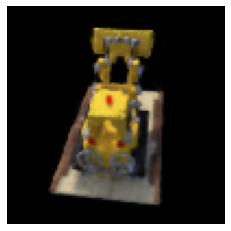

In [74]:
dataset = AutoNeRF.data.data.AutoNeRF_Dataset("/gdrive/My Drive/chair.npz")


images = torch.from_numpy(dataset.images).to(device)
focal_length = torch.from_numpy(dataset.focal_length).to(device)
poses = torch.from_numpy(dataset.poses).to(device)

height, width = images.shape[1:3]

UP = torch.tensor([0.,0.,1.]).unsqueeze(dim=0).to(device)
translation = torch.tensor(dataset.poses[:, :3,3]).to(device)

center = torch.zeros(3).to(device)
radius = torch.norm(translation[0] - center, p=2)
height, width = 100,100
print(radius, center)

SCENE_RADIUS = 2
near_thresh, far_thresh = get_thresholds(radius)

num_encoding_functions = 6
# Specify encoding function.
encode = lambda x: nerf.positional_encoding(x, num_encoding_functions=num_encoding_functions)
# Number of depth samples along each ray.
depth_samples_per_ray = 228

def show(image, permutation=(0,1,2)):
    grid_img = torchvision.utils.make_grid(image, nrow=5)
    plt.imshow(grid_img.permute(permutation))
    plt.axis('off')
    plt.show()

def get_thresholds(r):
    diff = r - SCENE_RADIUS
    tn = diff
    tf = diff + 2*SCENE_RADIUS
    return tn, tf

def get_new_pose(center, radius):
    """
    generates a new pose / perspective for the NeRF model
    """

    rot = random_rotation().to(device)
    unit_x = torch.tensor([1.,0.,0.]).to(device)
    new_t = center + radius*(rot @ unit_x)

    new_t[2] = torch.abs(new_t[2])


    cam_rot = look_at_rotation(at=new_t.unsqueeze(dim=0), 
                               camera_position=center.unsqueeze(dim=0),up=UP) #tform_cam2world[0, :3, :3]#

    #cam_rot = torch.transpose(cam_rot, 1,2)
    transform = torch.zeros((4,4))#.to(device)
    
    transform[:3, :3] = cam_rot
    transform[:3, 3] = new_t
    transform[3, 3] = 1
    #print(look_at_rotation(center))
    return transform


depth_samples_per_ray = 240

r = torch.tensor(np.random.uniform(radius.item()-1, radius.item()+1)).to(device)
near_thresh, fat_thresh = get_thresholds(r)

new_pose = get_new_pose(center, r).to(device)
predicted = nerf.nerf_prediction(model, height, width, focal_length, new_pose,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             encode, nerf.get_minibatches)

show(predicted.cpu())